# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", 
                                        target_folder="batches", gather_dictionary=True, batch_size=32)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, cache_theta=True, topic_names=topic_names, class_ids={"text":1,"author":1})

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="texts", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="authors", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
# Ваш код
model_artm.regularizers.add(
artm.SmoothSparsePhiRegularizer(tau=1e5, dictionary=dictionary, topic_names='bcg', class_ids=['text']))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5,
    dictionary=dictionary, class_ids=['text'], topic_names=["sbj"+str(i) for i in range(T-1)]))

Выполните еще 15 проходов по коллекции.

In [11]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [12]:
# Ваш код
top_wrd = model_artm.score_tracker["texts"].last_tokens
for i in model_artm.topic_names:
    print i + ': ' + ' '.join( top_wrd[i] )

sbj0: церковь средневековый власть император совершать русь святой папа александр вера князь славянский сага поэзия брат
sbj1: планета земля вокруг вода атмосфера солнце образовываться солнечный белый газ размер карлик поверхность спутник орбита
sbj2: система образование движение двигаться трудность участник положительный относительность тест моделирование школьный архитектура задание подготовка курс
sbj3: наука культура рассказывать понятие общество кандидат исторический каков доктор культурный концепция восприятие сознание феномен формироваться
sbj4: право правовой римский юрист юридический договор должник собственность обязательство признавать защита владение требование исполнение суд
sbj5: материал свет применение создание использование электронный оптический полимер импульс прибор технология канал увеличивать устройство трехмерный
sbj6: книга литература тема фильм литературный текст автор статья произведение написать документ посвящать кино искусство массовый
sbj7: смерть ритуал г

In [13]:
top_auth = model_artm.score_tracker["authors"].last_tokens
for i in model_artm.topic_names:
    print i + ': ' + ' '.join( top_auth[i] )

sbj0: Александр_Марей Фёдор_Успенский Алексей_Юдин Татьяна_Бобровникова Игорь_Данилевский Елена_Уханова Ольга_Брилева Владимир_Петрухин Олег_Воскобойников Григорий_Бондаренко Екатерина_Болтунова Ольга_Тогоева Елена_Браун Ольга_Вайнштейн Павел_Уваров
sbj1: Сергей_Попов Александр_Марков Дмитрий_Вибе Валерий_Сулейманов Дмитрий_Титов Зоригто_Намсараев Татьяна_Смоктунович Сергей_Наугольных Николай_Дронин Владимир_Кузнецов Роман_Рафиков Александр_Слободкин Елизавета_Ривкина Андрей_Глазовский Наталья_Новикова
sbj2: Елена_Брызгалина Александр_Поддьяков Владимир_Мележик Михаил_Пантелеев Татьяна_Клячко Эмиль_Ахмедов Михаил_Фейгельман Даниэль_Сельва Антон_Суворов Владимир_Редько Илья_Щуров Ольга_Вайнштейн Алексей_Котов Кристофер_Уиншип Александра_Скрипченко
sbj3: Виталий_Куренной Михаил_Соколов Павел_Уваров Ольга_Артёмова Александр_Гофман Дмитрий_Громов Пётр_Турчин Алексей_Руткевич Владимир_Миронов Андрей_Лукашов Сергей_Арутюнов Николай_Плотников Владимир_Бобровников Ирина_Савельева Светлана_Бань

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [14]:
sbj_topic_labels = ["История",
    "Планета",
    "Учёба",
    "Наука",
    "Право",
    "Материал",
    "Литература",
    "Смерть",
    "Химия",
    "Физика",
    "Россия",
    "Семья",
    "Биология",
    "Христианство",
    "Космос",
    "Информатика",
    "География",                
    "Философия",
    "Грамматика",
    "Революция",
    "Город",
    "Медицина",
    "Социология",
    "Схема",
    "Мифы",
    "Программирование",
    "Политика",
    "Генетика",
    "Сверхпроводимость",]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [15]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = model_artm.get_phi(class_ids=['author'])
theta = model_artm.get_theta()
print 'phi_a.shape:', phi_a.shape, 'theta.shape:', theta.shape

phi_a.shape: (539, 30) theta.shape: (30, 1728)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

D:\Python\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


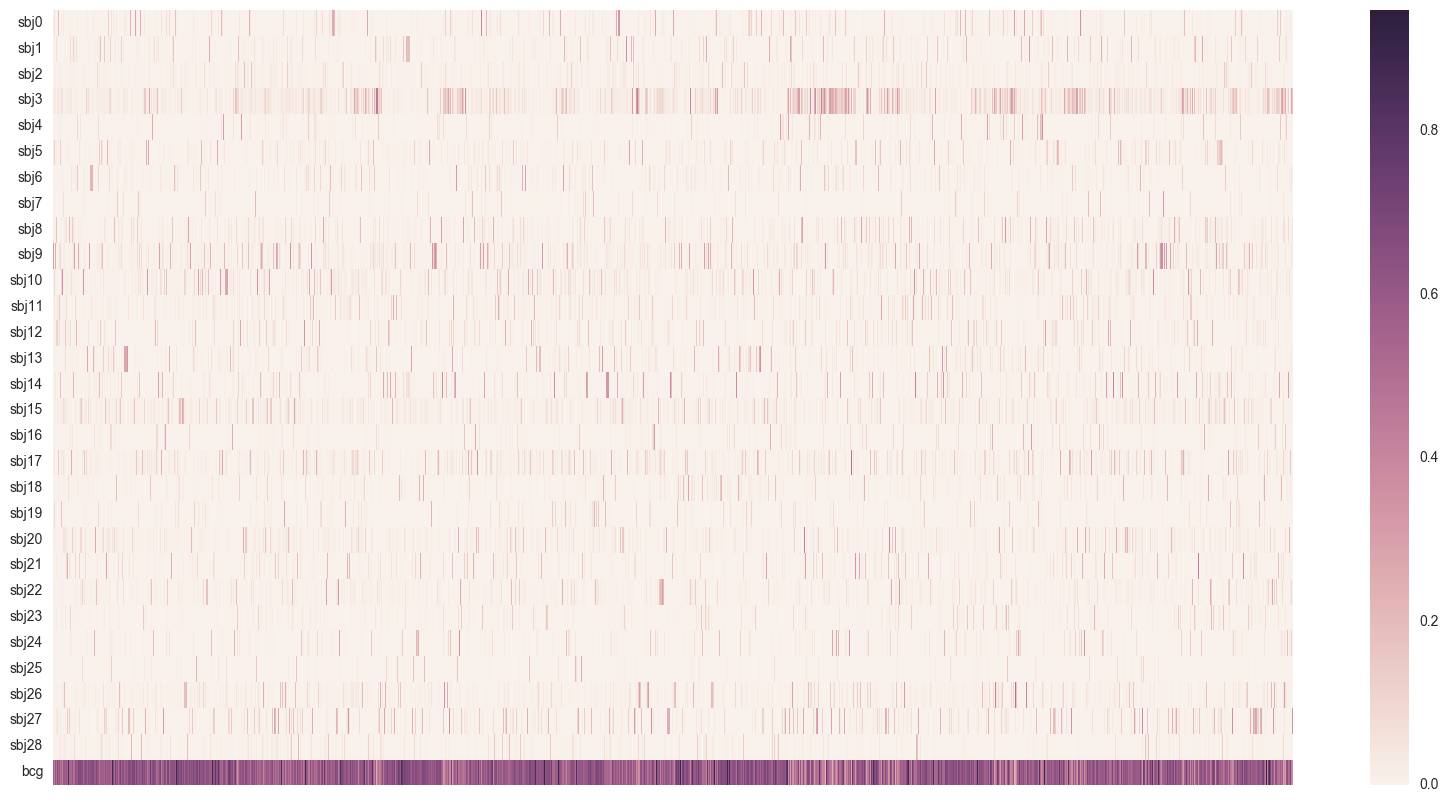

In [16]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(theta[0:100], xticklabels=False)

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [17]:
# Ваш код
S = theta.sum( axis=1 )
T = pd.DataFrame( data=S/S.sum(), columns=['p(t)'])
T.index = topic_labels
T.sort_values('p(t)')

,p(t)
Программирование,0.003608
Смерть,0.004360
География,0.006386
Революция,0.006555
Схема,0.007655
Сверхпроводимость,0.008020
Право,0.008487
Грамматика,0.009010
Учёба,0.009709
Мифы,0.009923


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

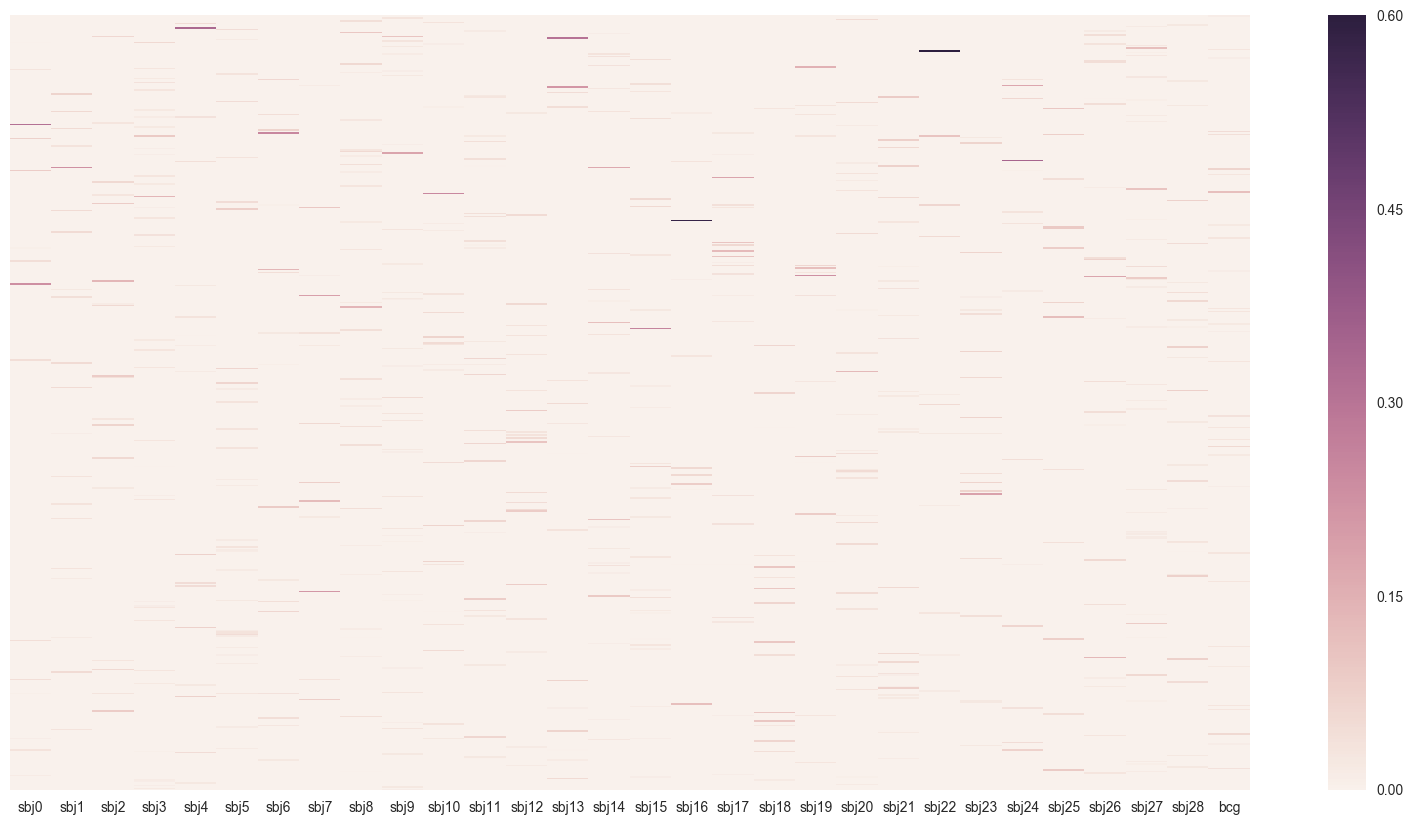

In [18]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(phi_a,yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [19]:
for ind, row in phi_a.iterrows():
    cnt = row[row > 0.01].count()
    print ind, cnt
print '\n' + 'Самые значимые:'
for ind, row in phi_a.iterrows():
    cnt = row[row > 0.01].count()
    if cnt >= 3:
        print ind, cnt

Ярослав_Исполатов 0
Сергей_Демокритов 1
Руслан_Смелянский 1
Александр_Апт 1
Людмила_Новикова 1
Александр_Парфенов 1
Джеффри_Шнапп 1
Дмитрий_Чудаков 1
Дмитрий_Дождев 1
Владимир_Шалаев 1
Марк_Харрисон 2
Валерий_Фокин 1
Ави_Лёб 1
Сергей_Гуриев 1
Эмиль_Ахмедов 2
Алексей_Муравьёв 1
Виктор_Быков 1
Павел_Пахлов 1
Павел_Уваров 1
Сергей_Соколовский 2
Светлана_Боринская 1
Эдуард_Боос 1
Евгений_Шеваль 1
Нина_Сумбатова 1
Виктор_Вахштайн 1
Хопи_Хукстра 0
Валерий_Рубаков 2
Сергей_Науменко 1
Андрей_Савельев-Трофимов 1
Aльберт_Давлетшин 0
Александр_Каплан 1
Сергей_Афонцев 1
Сергей_Пекарский 1
Валентин_Ненайденко 1
Олег_Верходанов 1
Алексей_Миллер 1
Владимир_Бобровников 1
Григорий_Бондаренко 1
Дмитрий_Гитман 1
Игорь_Ломоносов 1
Виктор_Зайченко 1
Анатолий_Лиходед 1
Евгений_Куликов 1
Светлана_Кузнецова 1
Мария_Штейнман 2
Александр_Шварцбург 1
Ольга_Артёмова 1
Игорь_Уточкин 1
Сергей_Неклюдов 2
Дмитрий_Беляев 1
Антон_Бирюков 1
Николай_Плотников 1
Станислав_Клименко 1
Андрей_Виноградов 1
Александр_Марков 1


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [20]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [21]:
# Ваш код
p_ta = phi_a.get_values() * T.get_values().reshape((1,30)) / phi_a.get_values().dot(T.get_values())
mds = MDS(n_components = 2, n_init = 1, max_iter = 100, dissimilarity='precomputed')
p_ta_mds = mds.fit_transform(pairwise_distances(p_ta, metric='cosine'))

Визуализируйте найденные двумерные представления с помощью функции scatter. 

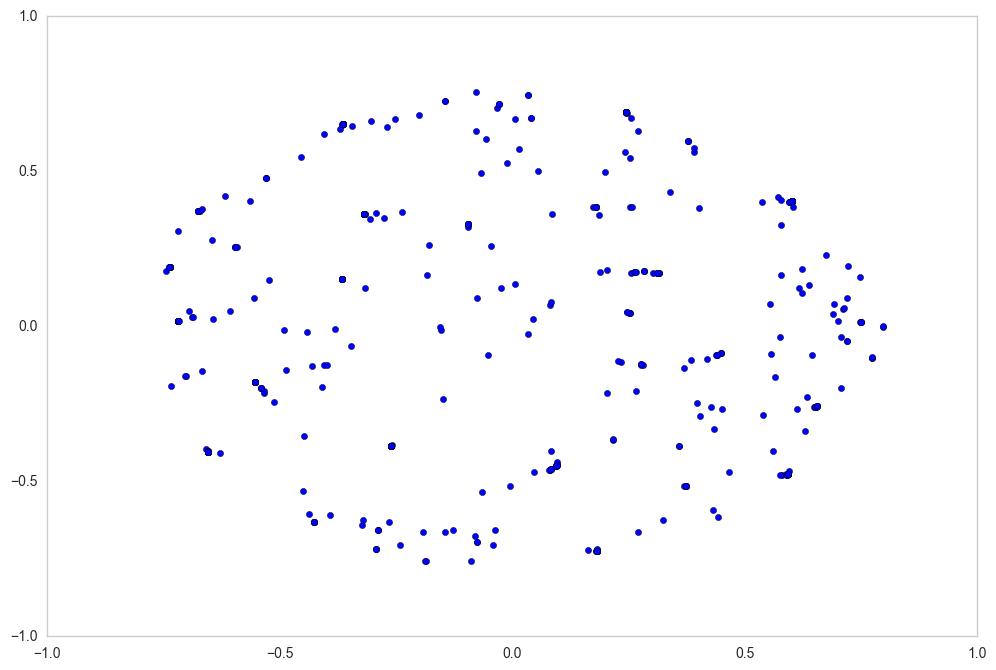

In [22]:
# Ваш код
plt.figure(figsize=(12, 8))
plt.scatter(p_ta_mds[:, 0], p_ta_mds[:, 1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [ ]:
import matplotlib.cm as cm
T=30
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
plt.figure(figsize=(100, 75))
plt.scatter(p_ta_mds[:, 0], p_ta_mds[:, 1], s=150, c=colors, cmap=p_ta.argmax(axis=1))
for idx, xy in enumerate( p_ta_mds ):
    plt.annotate(phi_a.index[idx], xy=xy)
plt.savefig('postnauka.pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [ ]:
# Ваш код
p_dt = theta.get_values()/theta.sum(axis=1).reshape((30,1))
i_p_dt = np.array(p_dt.argmax(axis=1).reshape((30,1)))
for j in range(1,p_dt.shape[1]):
    for i in range(p_dt.shape[0]):
        p_dt[i][i_p_dt[i][j-1]] = -1.
    i_p_dt = np.hstack((i_p_dt,p_dt.argmax(axis=1).reshape((30,1))))

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [ ]:
print "http://yandex.ru"   # получится кликабельная ссылка

Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [ ]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [ ]:
# Ваш код
tokens = model_artm.score_tracker["texts"].last_tokens
for idx, topic_name in enumerate(topic_labels):
    display(HTML(u"<h2>"+topic_name.decode('UTF-8')+"</h2>"))
    display(HTML(u'<h4>'+' '.join(tokens[topic_names[idx]][:10] )+'</h4>'))
    url_arr = []
    for n in range(10): 
        display(HTML(u"<ul>"+'<li>'+u'<a href="'+theta.columns[i_p_dt[idx][n]]+'">'+
                     theta.columns[i_p_dt[idx][n]]+'</a>'+'</li>'+"</ul>"))

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 